# Comparison of inferred velocity and latent times

**Requires**

* `fitted_values.csv` generated by `pancreas.ipynb`

## Library imports

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scvi
import scvelo as scv
import torch
from velovi import VELOVI

sys.path.append("../..")
from utils._simulation import simulate_data
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [2]:
scvi.settings.dl_pin_memory_gpu_training = False

In [3]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [4]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definition

In [5]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, var_names=adata.var_names, use_raw=True, n_jobs=8
    )
    scv.tl.velocity(adata, mode="dynamical")

In [6]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocity"] = velocities / scaling
    bdata.layers["latent_time"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

## Data loading

In [7]:
df = pd.read_csv(DATA_DIR / "pancreas" / "fitted_values.csv", index_col=0).sample(frac=0.5)
df.head()

fit_alpha  fit_beta  fit_gamma     fit_t_ model
index                                                  
Nptx2    0.083103  0.108307   0.188514  14.631201    VI
Rbpjl    0.026645  0.337411   0.206346  21.273163    VI
Syt7     0.148926  0.282632   0.205117  17.131525    EM
Cdc14b   0.158472  0.277238   0.203630  19.300320    EM
Cxxc4    0.127181  0.183402   0.267991  12.156104    VI

In [8]:
adata = simulate_data(
    alpha=df['fit_alpha'].values,
    beta=df['fit_beta'].values,
    gamma=df['fit_gamma'].values,
    t_switch=df['fit_t_'].values,
)
adata.var['model'] = df['model'].values
adata

AnnData object with n_obs × n_vars = 3000 × 1074
    obs: 'true_t'
    var: 'true_t_', 'true_alpha', 'true_beta', 'true_gamma', 'true_scaling', 'model'
    layers: 'unspliced', 'spliced', 'true_velocity'

In [9]:
adata.layers['Mu'] = adata.layers['unspliced']
adata.layers['Ms'] = adata.layers['spliced']

bdata = adata.copy()

## Parameter inference

### EM model

In [10]:
fit_scvelo(adata)

recovering dynamics (using 8/14 cores)


  0%|          | 0/1074 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


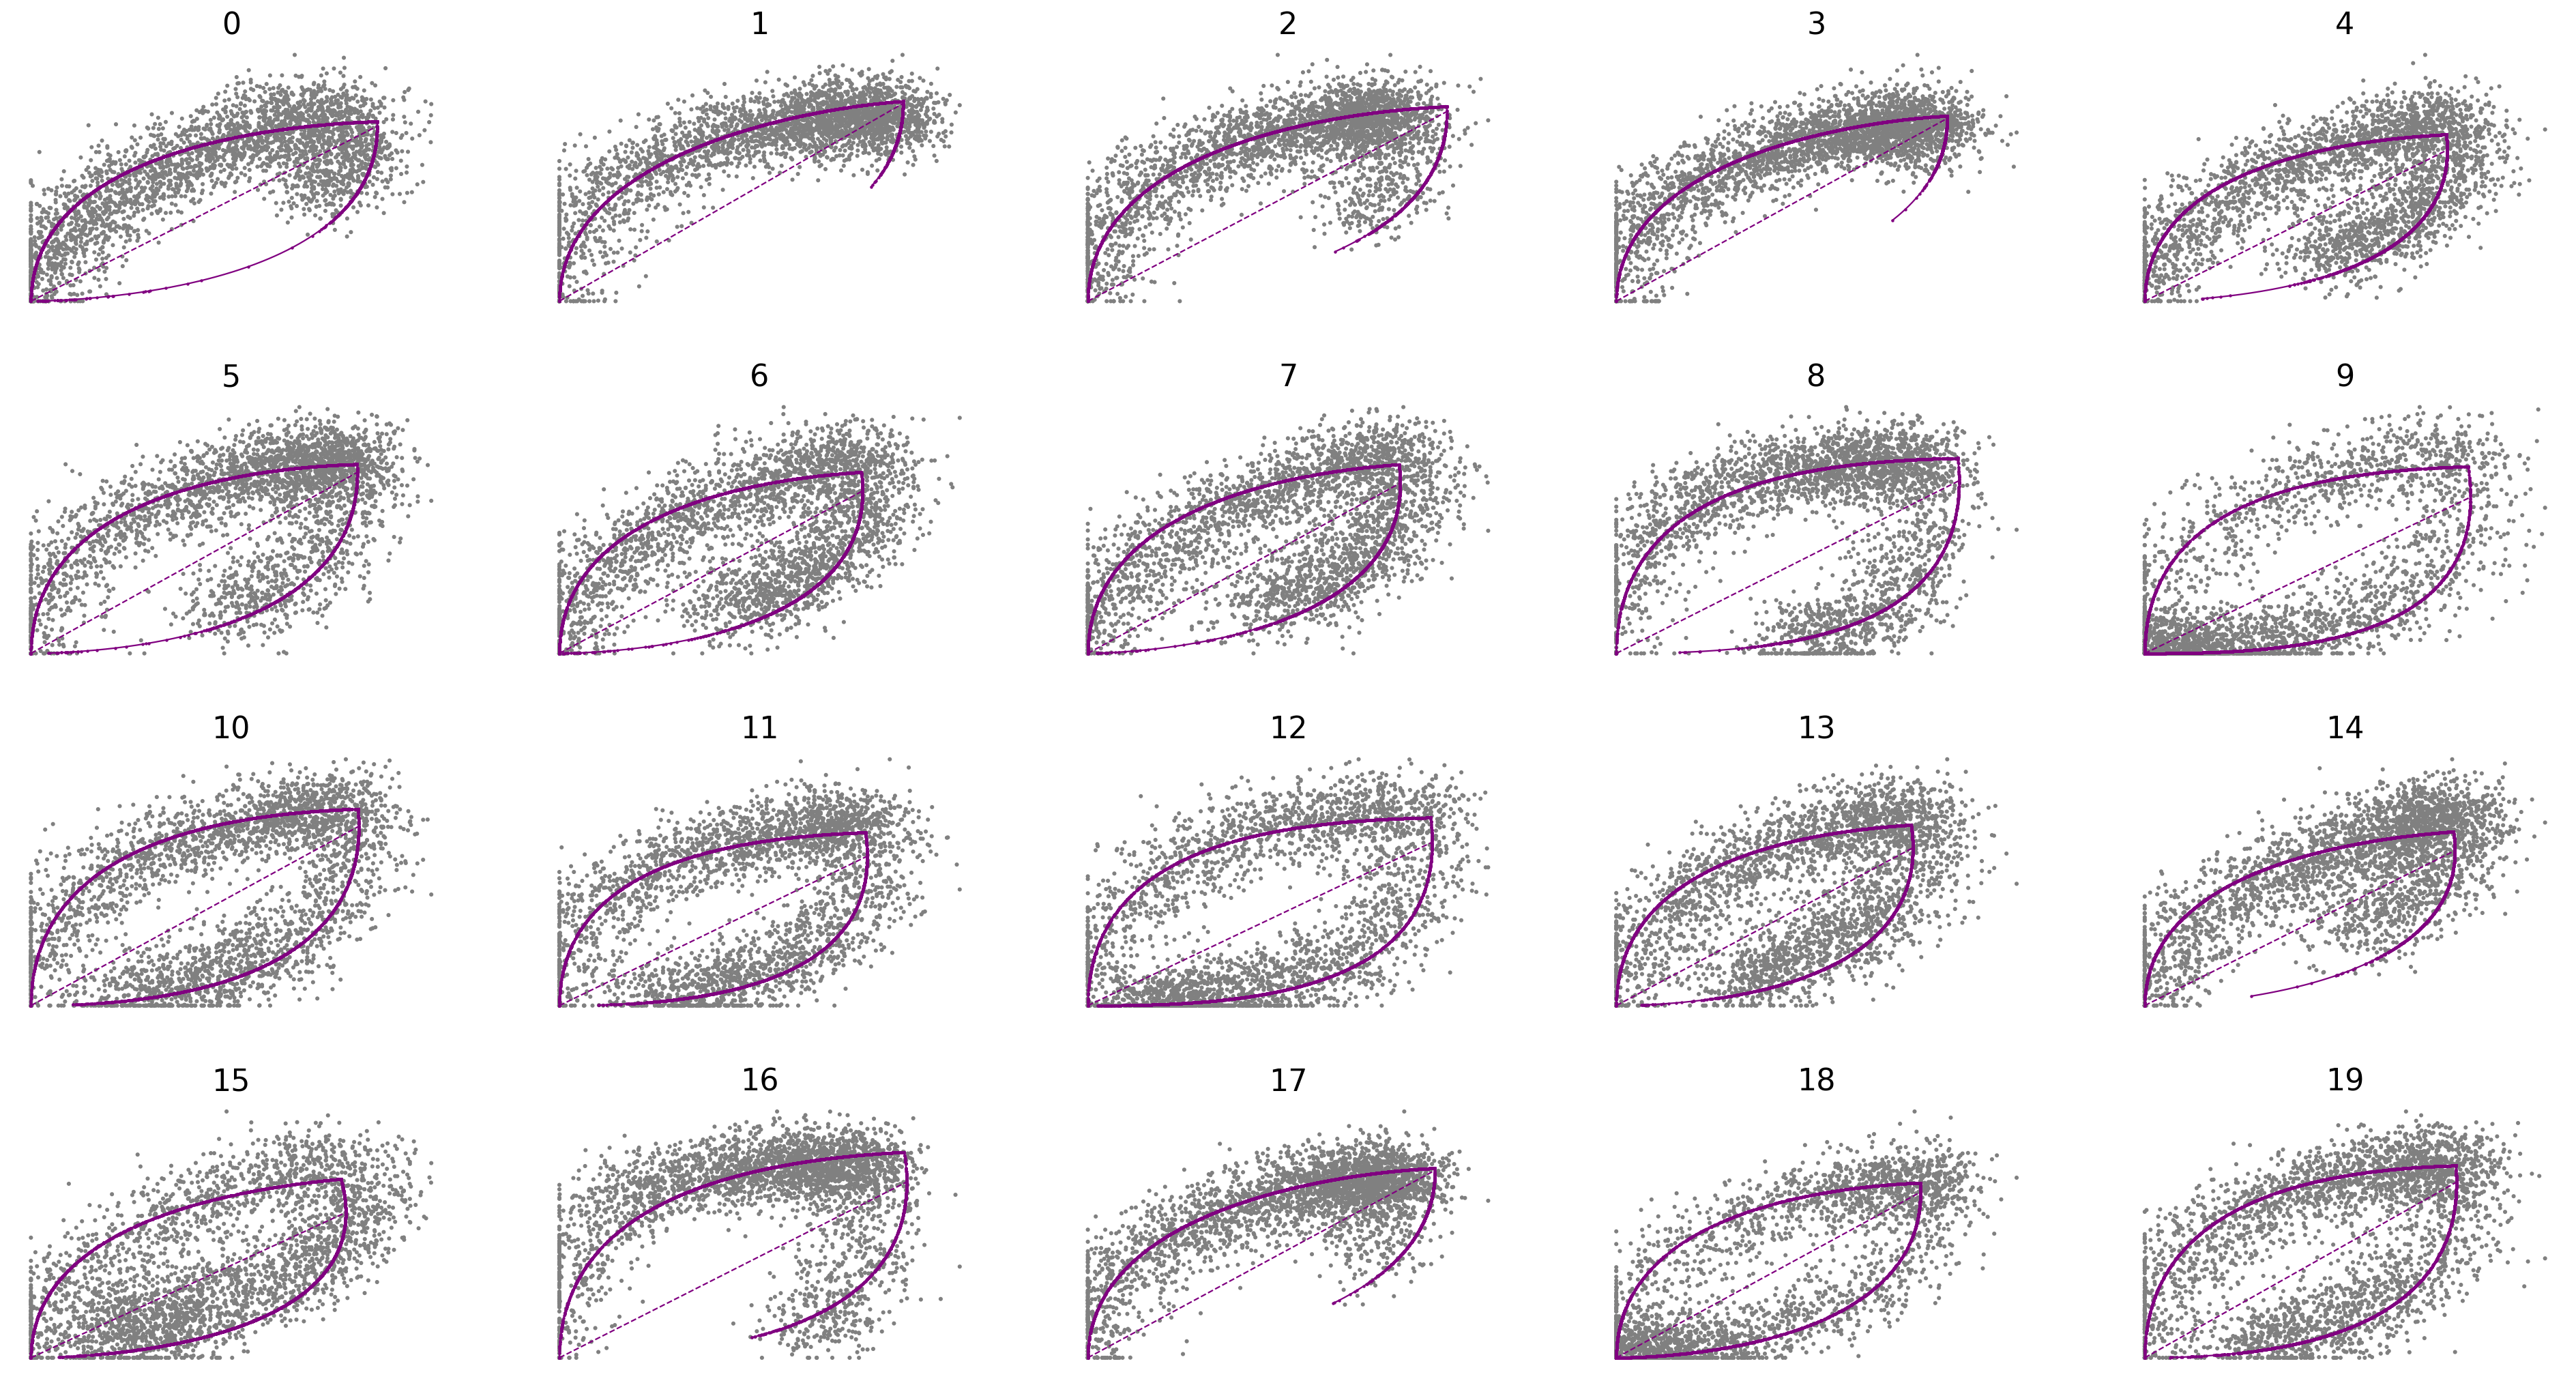

In [11]:
scv.pl.scatter(adata, basis=adata.var_names[:20], ncols=5, frameon=False)

### VI model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 279/500:  56%|█████▌    | 279/500 [02:00<01:35,  2.31it/s, loss=-1.97e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1923.831. Signaling Trainer to stop.


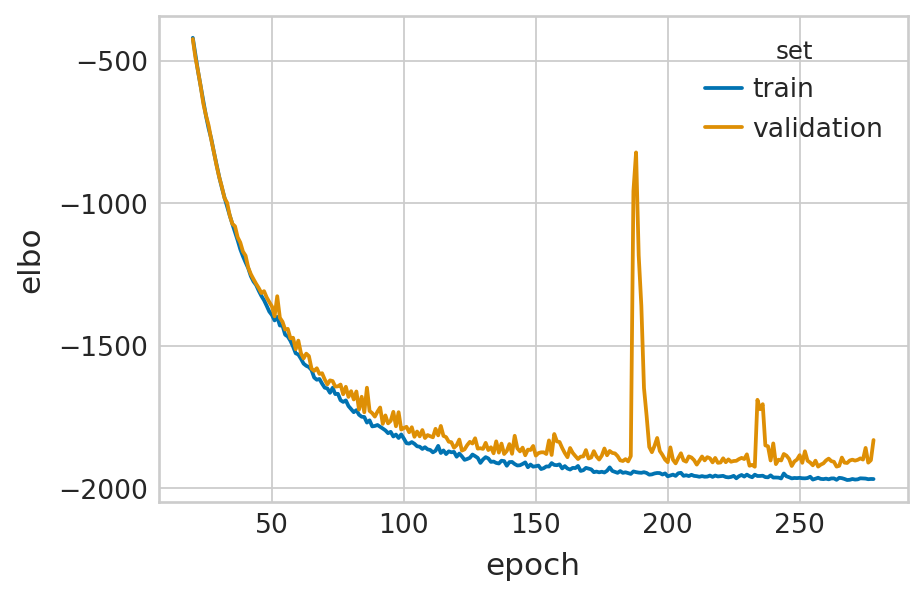

In [12]:
velovi_vae = fit_velovi(bdata)

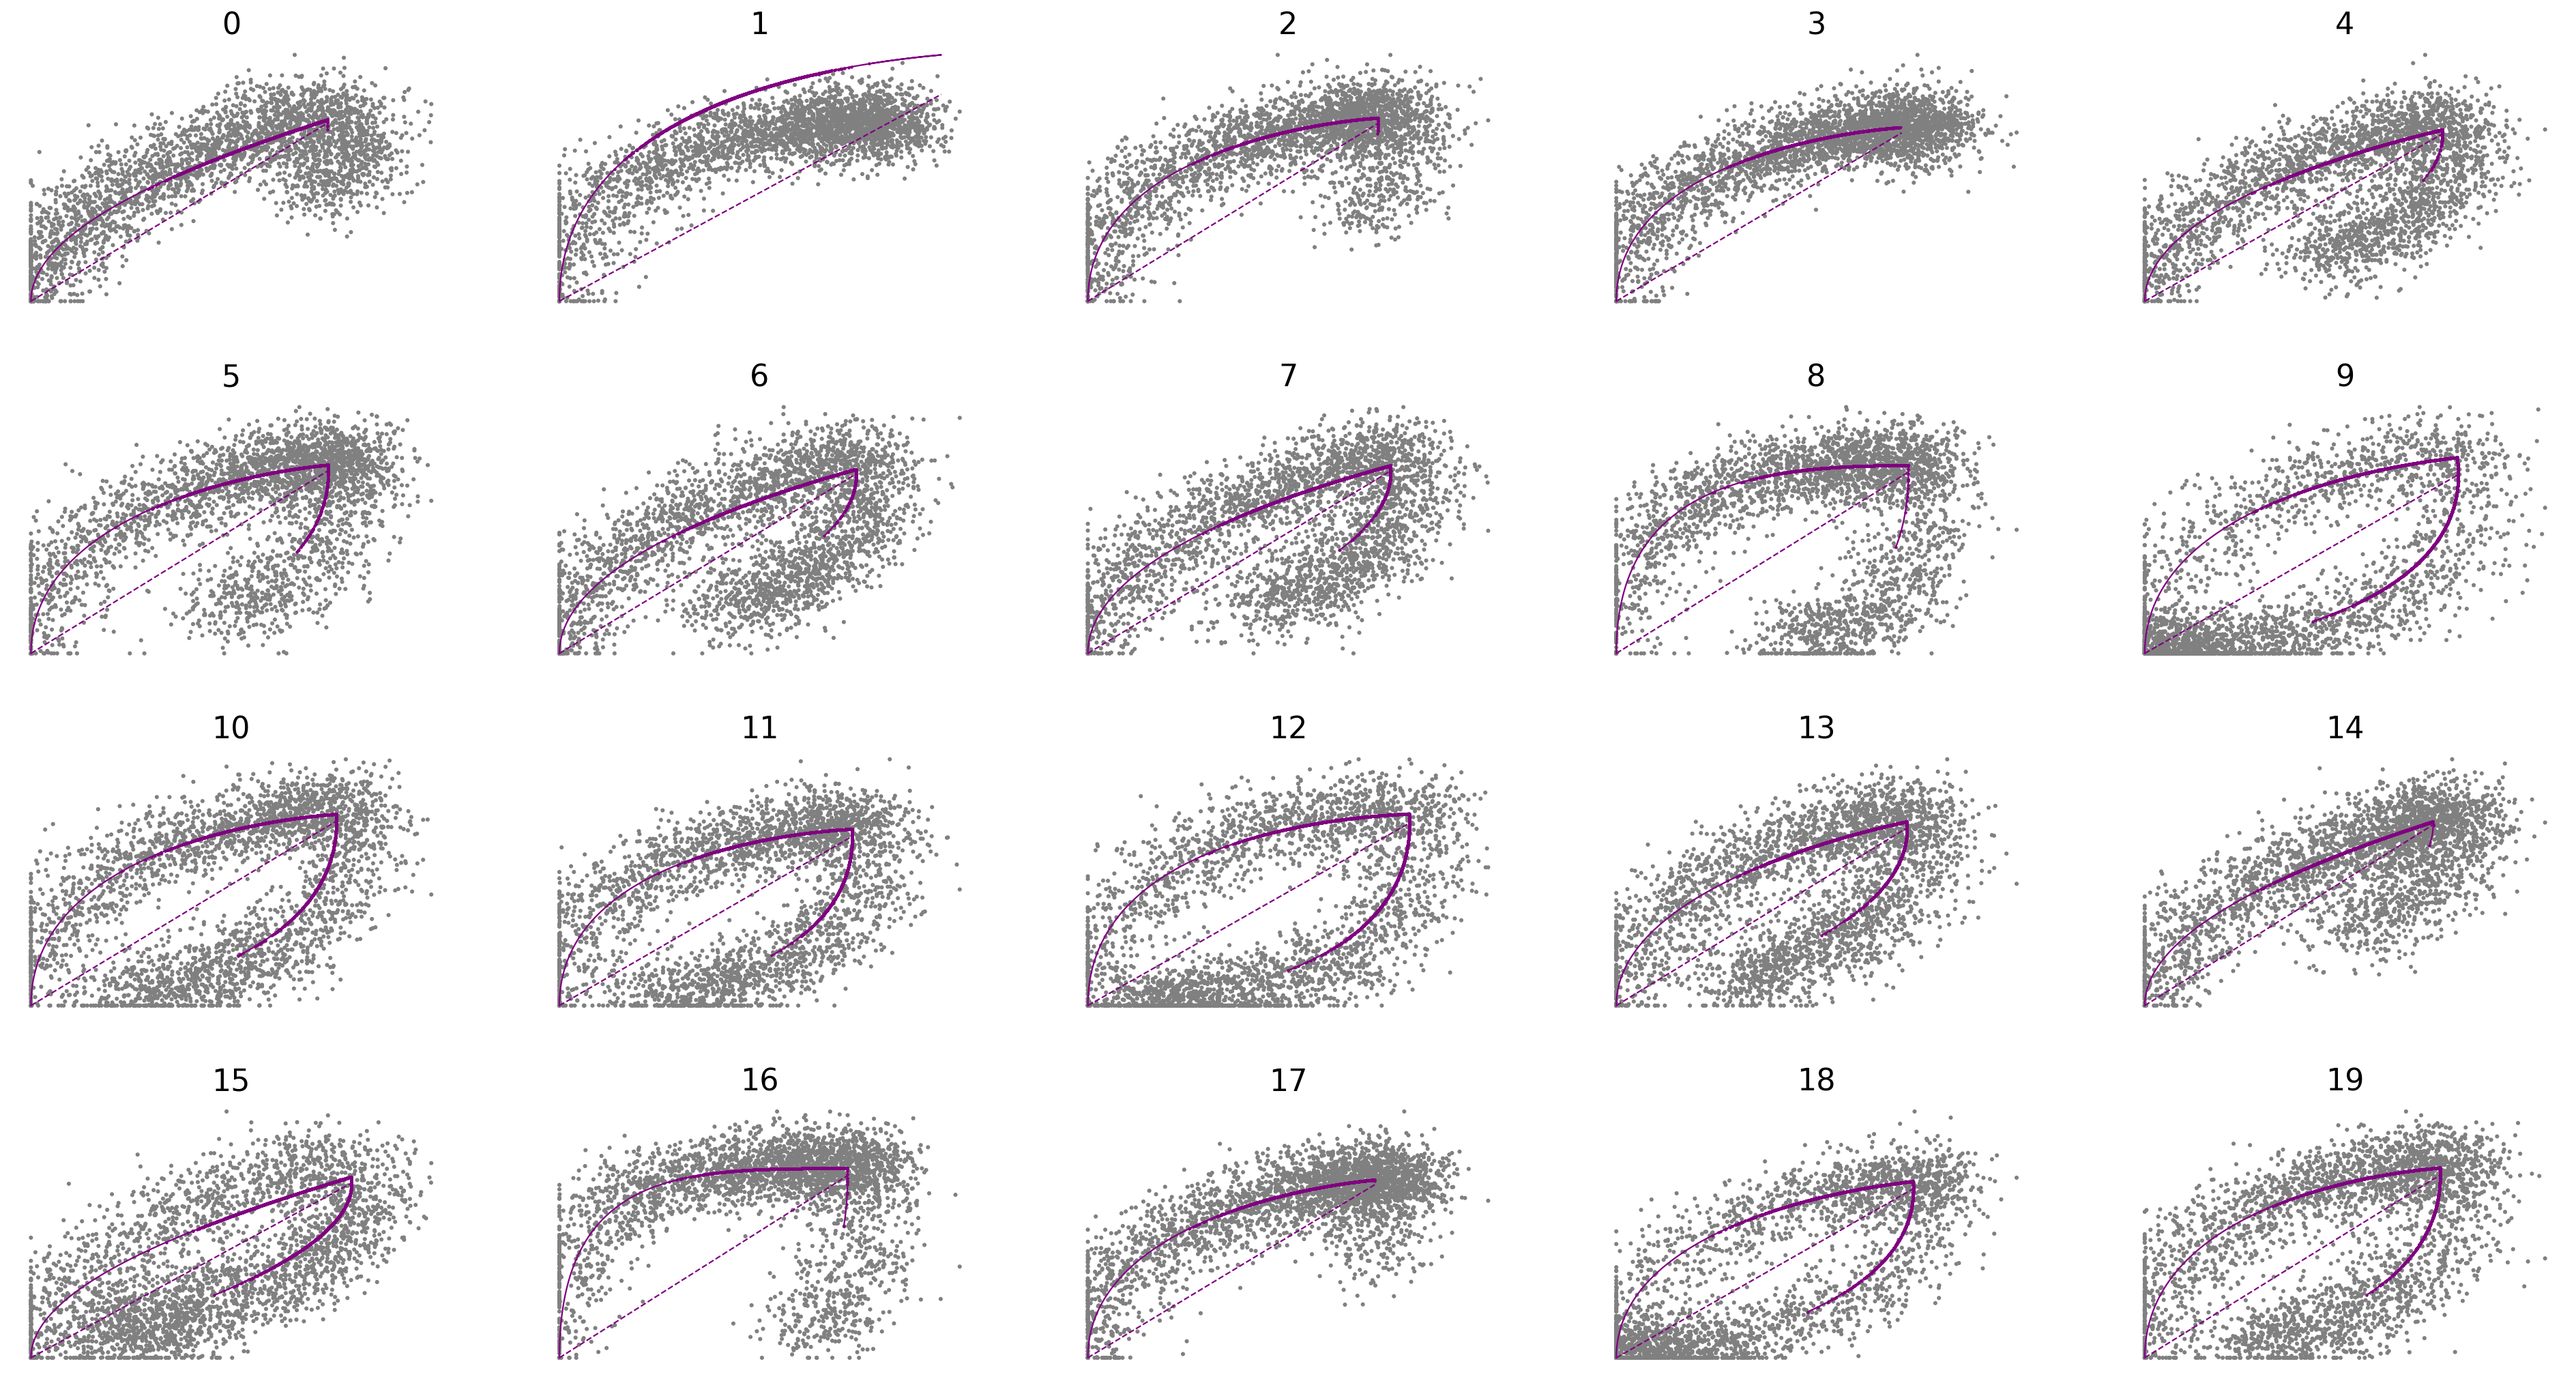

In [13]:
scv.pl.scatter(bdata, basis=bdata.var_names[:20], ncols=5, frameon=False)

## Correlation analysis

### Velocity

In [14]:
corr_df_velocity = pd.DataFrame(columns=["EM", "VI"], index=np.arange(len(adata.var_names)))

for var_id in range(len(adata.var_names)):
    x = adata.layers["velocity"][:, var_id]
    y = adata.layers["true_velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "EM"] = pearsonr(x, y)[0]

    x = bdata.layers["velocity"][:, var_id]
    corr_df_velocity.loc[var_id, "VI"] = pearsonr(x, y)[0]

corr_df_velocity['model'] = adata.var['model'].values

In [15]:
(corr_df_velocity["VI"] > corr_df_velocity["EM"]).mean()

0.9376163873370578

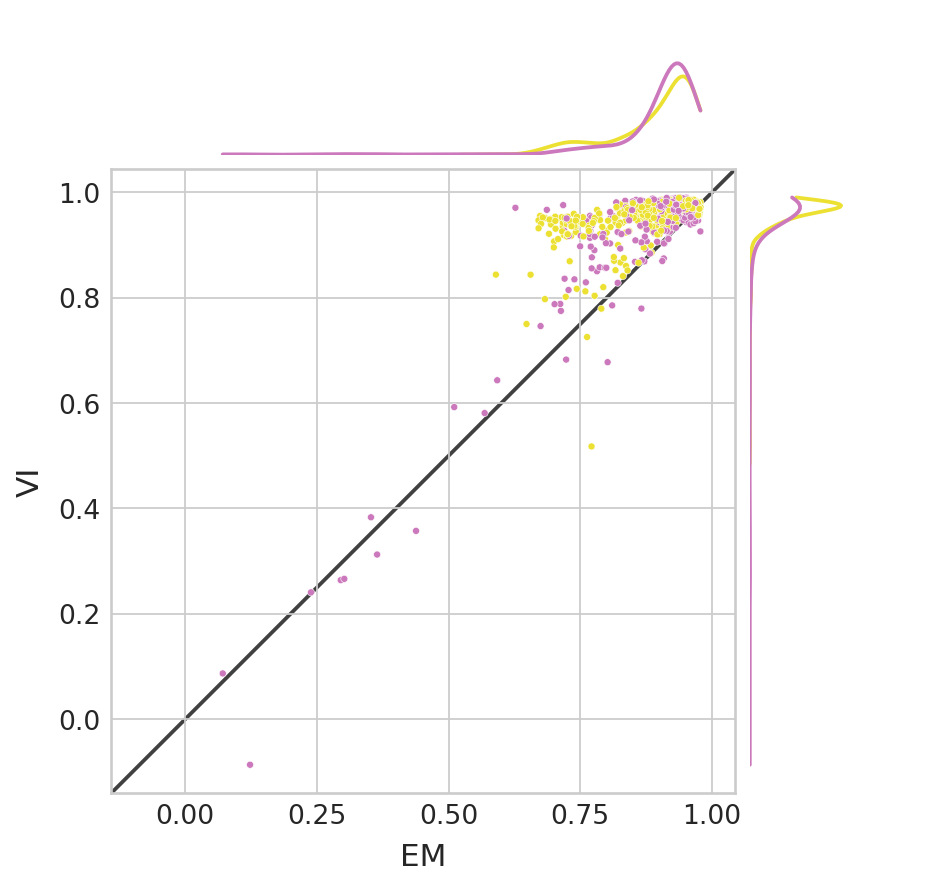

In [17]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.015
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histx.axis("off")
    ax_histy.axis("off")

    clipy = (corr_df_velocity["VI"].min(), corr_df_velocity["VI"].max())
    clipx = (corr_df_velocity["EM"].min(), corr_df_velocity["EM"].max())

    palette = dict(
        zip(
            ["EM", "VI"],
            [
                sns.color_palette("colorblind").as_hex()[4],
                sns.color_palette("colorblind").as_hex()[8]
            ]
        )
    )

    sns.kdeplot(
        data=corr_df_velocity,
        y="VI",
        hue="model",
        ax=ax_histy,
        legend=False,
        clip=clipy,
        palette=palette,
    )
    sns.kdeplot(
        data=corr_df_velocity,
        x="EM",
        hue="model",
        ax=ax_histx,
        legend=False,
        clip=clipx,
        palette=palette,
    )
    
    sns.scatterplot(data=corr_df_velocity, x="EM", y="VI", hue='model', s=10, ax=ax, palette=palette, legend=False)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_velo_correlation.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [18]:
ttest_res = ttest_ind(
    corr_df_velocity["VI"].values.astype(float),
    corr_df_velocity["EM"].values.astype(float),
    equal_var=False
)
ttest_res

Ttest_indResult(statistic=15.858217619574068, pvalue=1.4333381236707924e-53)

In [19]:
if ttest_res.pvalue < 0.001:
    significance = "***"
elif ttest_res.pvalue < 0.01:
    significance = "**"
elif ttest_res.pvalue < 0.1:
    significance = "*"

In [20]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

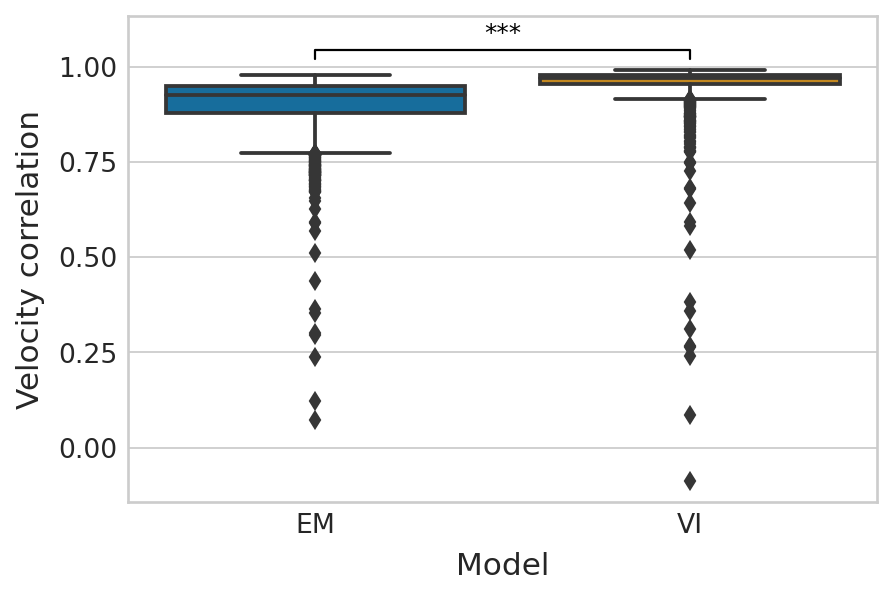

In [21]:
df = pd.melt(corr_df_velocity[["EM", "VI"]]).rename(columns={"variable": "Model", "value": "Velocity correlation"})
palette = dict(zip(["EM", "VI"], sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df, x="Model", y="Velocity correlation", palette=palette, ax=ax)
        
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, c="k"
    )
    ylim_lower, ylim_upper = ax.get_ylim()
    ax.set_ylim([ylim_lower, ylim_upper * 1.03])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_velo_correlation_boxplot.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

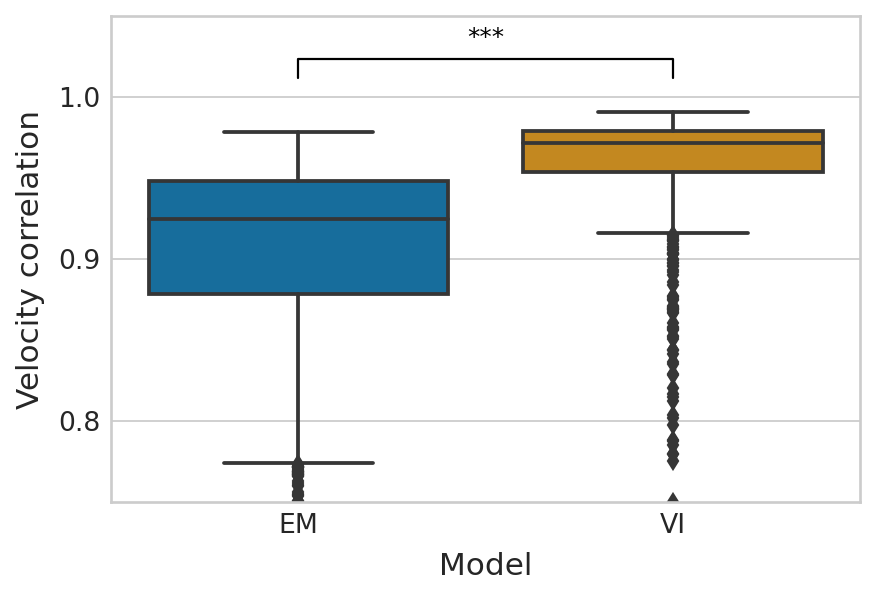

In [22]:
df = pd.melt(corr_df_velocity[["EM", "VI"]]).rename(columns={"variable": "Model", "value": "Velocity correlation"})
palette = dict(zip(["EM", "VI"], sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df, x="Model", y="Velocity correlation", palette=palette, ax=ax)
        
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        bracket_level=0.98,
        bracket_height=0.01,
        text_height=0.005,
        lw=1,
        c="k",
    )
    ax.set_ylim([0.75, 1.05])

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_velo_correlation_boxplot_clipped.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

### Latent time

In [23]:
corr_df_time = pd.DataFrame(columns=["EM", "VI"], index=np.arange(len(adata.var_names)))

for var_id in range(len(adata.var_names)):
    x = adata.layers["fit_t"][:, var_id]
    y = adata.obs["true_t"]
    corr_df_time.loc[var_id, "EM"] = pearsonr(x, y)[0]

    x = bdata.layers["fit_t"][:, var_id]
    corr_df_time.loc[var_id, "VI"] = pearsonr(x, y)[0]

corr_df_time['model'] = adata.var['model'].values

In [24]:
(corr_df_time["VI"] > corr_df_time["EM"]).mean()

0.8202979515828678

In [25]:
ttest_res = ttest_ind(
    corr_df_time["VI"].values.astype(float),
    corr_df_time["EM"].values.astype(float),
    equal_var=False
)
ttest_res

Ttest_indResult(statistic=5.410308290240931, pvalue=6.996398279647197e-08)

In [26]:
if ttest_res.pvalue < 0.001:
    significance = "***"
elif ttest_res.pvalue < 0.01:
    significance = "**"
elif ttest_res.pvalue < 0.1:
    significance = "*"

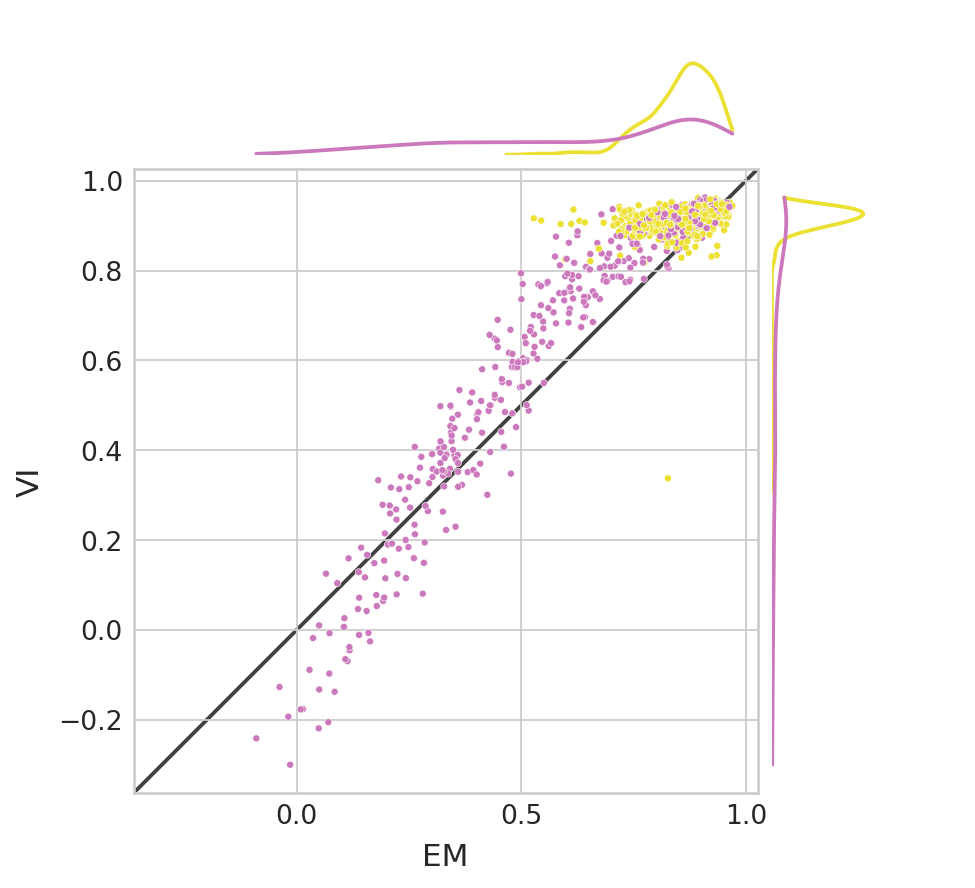

In [27]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')

    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.015
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histx.axis("off")
    ax_histy.axis("off")

    clipy = (corr_df_time["VI"].min(), corr_df_time["VI"].max())
    clipx = (corr_df_time["EM"].min(), corr_df_time["EM"].max())

    palette = dict(
        zip(
            ["EM", "VI"],
            [
                sns.color_palette("colorblind").as_hex()[4],
                sns.color_palette("colorblind").as_hex()[8]
            ]
        )
    )

    sns.kdeplot(
        data=corr_df_time,
        y="VI",
        hue="model",
        ax=ax_histy,
        legend=False,
        clip=clipy,
        palette=palette,
    )
    sns.kdeplot(
        data=corr_df_time,
        x="EM",
        hue="model",
        ax=ax_histx,
        legend=False,
        clip=clipx,
        palette=palette,
    )
    
    sns.scatterplot(data=corr_df_time, x="EM", y="VI", hue='model', s=10, ax=ax, palette=palette, legend=False)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_time_correlation.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

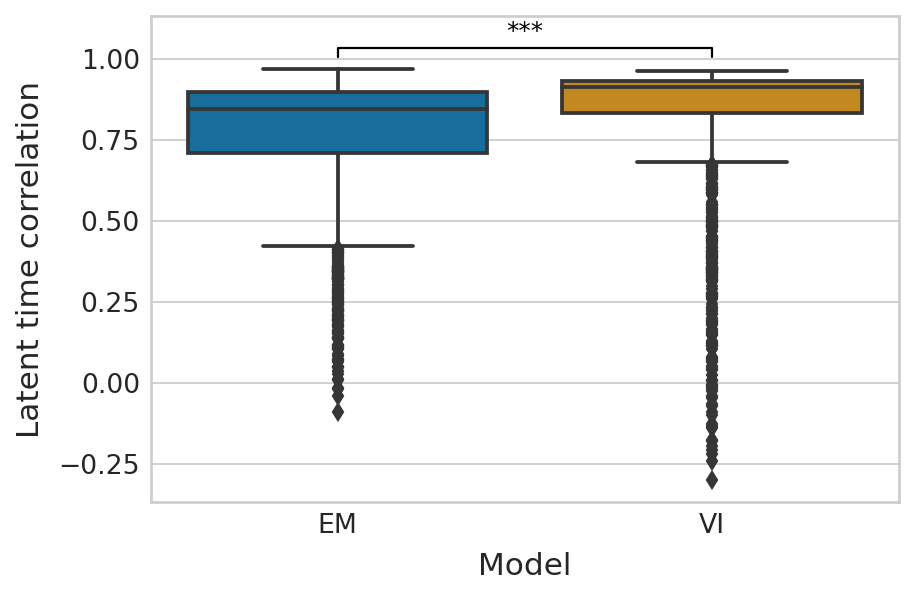

In [28]:
df = pd.melt(corr_df_time[["EM", "VI"]]).rename(columns={"variable": "Model", "value": "Latent time correlation"})
palette = dict(zip(["EM", "VI"], sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df, x="Model", y="Latent time correlation", palette=palette, ax=ax)
        
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, c="k"
    )
    ylim_lower, ylim_upper = ax.get_ylim()
    ax.set_ylim([ylim_lower, ylim_upper * 1.03])
    ax.set_yticks([-0.25, 0, 0.25, 0.5, 0.75, 1])

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_time_correlation_boxplot.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

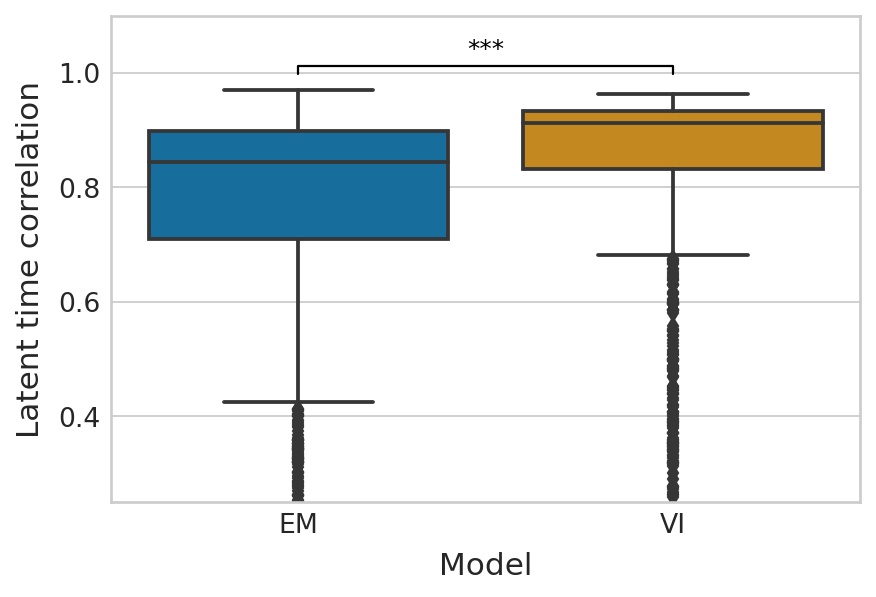

In [29]:
df = pd.melt(corr_df_time[["EM", "VI"]]).rename(columns={"variable": "Model", "value": "Latent time correlation"})
palette = dict(zip(["EM", "VI"], sns.color_palette("colorblind").as_hex()[:2]))

with mplscience.style_context():
    sns.set_style(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(data=df, x="Model", y="Latent time correlation", palette=palette, ax=ax)
        
    add_significance(
        ax=ax,
        left=0,
        right=1,
        significance=significance,
        bracket_level=0.98,
        bracket_height=0.01,
        text_height=0.005,
        lw=1,
        c="k",
    )
    ax.set_ylim([0.25, 1.1])

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'simulated_time_correlation_boxplot_clipped.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )